In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from unidecode import unidecode

# Change locale to "es_mx"
import locale
locale.setlocale(locale.LC_ALL, 'es_mx')

'es_mx'

In [151]:
dir_data = Path("data")

In [152]:
df = pd.read_excel(dir_data / "RegistroContable_17-1-2023.xls")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fecha          118 non-null    object 
 1   Cuenta         118 non-null    object 
 2   Categoría      118 non-null    object 
 3   Subcategorías  51 non-null     object 
 4   Nota           118 non-null    object 
 5   MXN            118 non-null    float64
 6   Ingreso/Gasto  118 non-null    object 
 7   Nota2          20 non-null     object 
 8   Importe        118 non-null    float64
 9   Moneda         118 non-null    object 
 10  Cuenta3        118 non-null    float64
dtypes: float64(3), object(8)
memory usage: 10.3+ KB


,Fecha,Cuenta,Categoría,Subcategorías,Nota,MXN,Ingreso/Gasto,Nota2,Importe,Moneda,Cuenta3
0,16/01/2023 00:47:08,Super cuenta universitaria Santander,Dinero mensual,NaN,Depósito de papá,200.0,Ingreso,NaN,200.0,MXN,200.0
1,16/01/2023 00:46:01,Super cuenta universitaria Santander,Dinero mensual,NaN,Depósito de mamá,200.0,Ingreso,NaN,200.0,MXN,200.0
2,15/01/2023 17:03:59,Cartera,Comida,Comidas fuera,Propina,38.0,Gasto,NaN,38.0,MXN,38.0
3,15/01/2023 17:03:03,Cartera,Transporte,Autobús,Viaje al centro,15.0,Gasto,NaN,15.0,MXN,15.0
4,15/01/2023 13:53:34,Super cuenta universitaria Santander,Comida,Bebidas,Soju,120.0,Gasto,A un lado de Choga Seúl,120.0,MXN,120.0


In [153]:
# sourcery skip: use-fstring-for-concatenation
df_clean = (
    df.rename(columns=lambda col: unidecode(col).lower().replace(r"/", "_"))
    .drop(columns=["nota2", "importe", "moneda", "cuenta3"])
    .astype(
        {
            "categoria": "category",
            "subcategorias": "category",
            "ingreso_gasto": "category",
            "cuenta": "string",
            "nota": "string",
        }
    )
    .replace({"ingreso_gasto": {"Dinero gastado": "Gasto"}})
    .assign(
        fecha=lambda frame: pd.to_datetime(
            frame.fecha.where(frame.fecha.str.contains(":"), frame.fecha + " 00:00:00"),
            format="%d/%m/%Y %H:%M:%S",
        )
    )
    .set_index("fecha")
    .sort_index()
)
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118 entries, 2022-11-14 06:59:34 to 2023-01-16 00:47:08
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   cuenta         118 non-null    string  
 1   categoria      118 non-null    category
 2   subcategorias  51 non-null     category
 3   nota           118 non-null    string  
 4   mxn            118 non-null    float64 
 5   ingreso_gasto  118 non-null    category
dtypes: category(3), float64(1), string(2)
memory usage: 5.5 KB


,cuenta,categoria,subcategorias,nota,mxn,ingreso_gasto
fecha,,,,,,
2022-11-14 06:59:34,Cartera,Modificar saldo,NaN,Ingresos,1284.50,Ingreso
2022-11-14 07:03:55,Mis metas Santander,Modificar saldo,NaN,Ingresos,2603.13,Ingreso
2022-11-14 07:45:21,Mercado pago,Modificar saldo,NaN,Ingresos,200.00,Ingreso
2022-11-14 08:27:14,Va y ven,Modificar saldo,NaN,Ingresos,23.00,Ingreso
2022-11-14 09:34:11,Mamá,Modificar saldo,NaN,Ingresos,9000.00,Gasto


In [170]:
(
    df_clean.groupby("ingreso_gasto")
    .mxn.resample("D")
    .sum()
    .unstack()
    .transpose()
    .cumsum()
    .ffill()
)

ingreso_gasto,Gasto,Ingreso
fecha,,
2022-11-14,9052.80,4110.63
2022-11-15,9202.80,4310.63
2022-11-16,9412.80,4310.63
2022-11-17,10081.12,4310.63
2022-11-18,10161.12,4310.63
...,...,...
2023-01-12,24106.51,12594.22
2023-01-13,24106.51,12594.22
2023-01-14,24106.51,12594.22


<AxesSubplot: xlabel='fecha'>

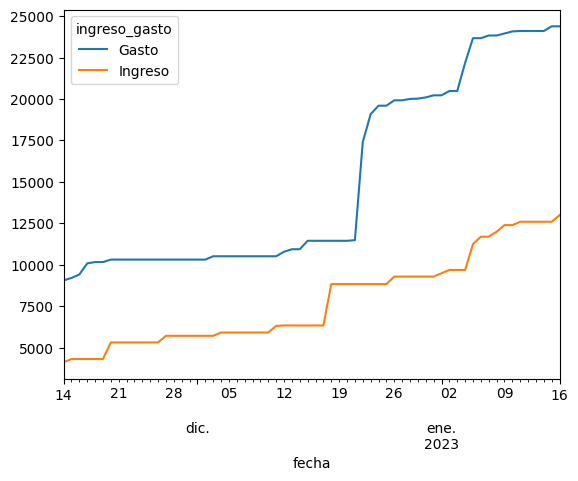

In [175]:
(
    df_clean.groupby("ingreso_gasto")
    .mxn.resample("D")
    .sum()
    .unstack()
    .transpose()
    .cumsum()
    .ffill()
    .plot()
)

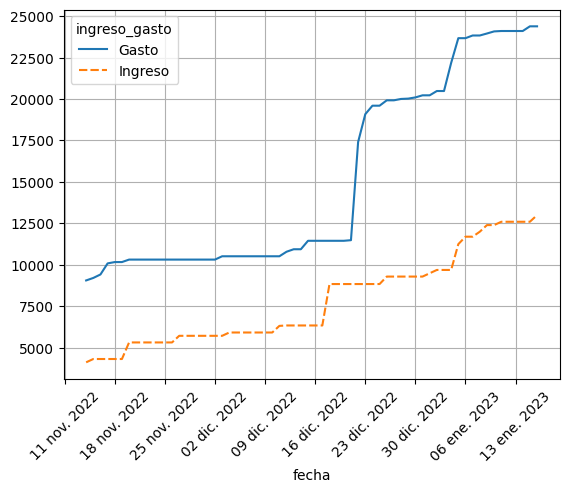

In [201]:
from matplotlib.dates import DateFormatter, DayLocator, MonthLocator, YearLocator
fig, ax = plt.subplots()
majlocator = DayLocator(interval=7)
ax.xaxis.set_major_locator(majlocator)

majformatter = DateFormatter("%d %b %Y")
ax.xaxis.set_major_formatter(majformatter)
sns.lineplot(
    data=df_clean.groupby("ingreso_gasto")
    .mxn.resample("D")
    .sum()
    .unstack()
    .transpose()
    .cumsum()
    .ffill(),
    ax=ax,
    errorbar=None)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()